# Time Series Analysis

## Load packages

In [1]:
import s3fs
import intake
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## Read catalog

In [2]:
# CMIP6 catalog
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

## Data exploration

In [3]:
# Catalog search
res = catalog.search(activity_id = ["CMIP", "ScenarioMIP"], # Historical data and future projections
                     source_id = ["GFDL-CM4", "GFDL-ESM4"], # NOAA models (Global Climate Model, Earth Systems)
                     experiment_id = ["historical", "ssp245", "ssp585"], # historical data (CMIP), middle of the road, fossil fueled development
                     table_id = "Amon", # Atmospheric monthly data
                     member_id = "r1i1p1f1", # Variant ID
                     variable_id = "tas") # Surface air temperature

In [4]:
# View results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/h...,NaN,20180701
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
4,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp245,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
5,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


## NOAA-GFDL-CM4 Model

## Extract data

In [5]:
# Read in the historical data file for CM4
hist_data = xr.open_zarr(res.df["zstore"][1], storage_options = {"anon": True})

# Read in the ssp245 data file for CM4
ssp245_data = xr.open_zarr(res.df["zstore"][4], storage_options = {"anon": True})

# Read in the ssp585 data file for CM4
ssp585_data = xr.open_zarr(res.df["zstore"][0], storage_options = {"anon": True})

## Data cleaning

In [6]:
# Concatenate historical and ssp245
CM4_ssp245 = xr.concat([hist_data, ssp245_data], dim = "time")

# Concatenate historical and ssp585
CM4_ssp585 = xr.concat([hist_data, ssp585_data], dim = "time")

# Convert time to datetime64 format
CM4_ssp245["time"] = CM4_ssp245.time.astype("datetime64[ns]")
CM4_ssp585["time"] = CM4_ssp585.time.astype("datetime64[ns]")

In [7]:
# Define min/max bounds for region of interest (Los Angeles County, CA)
lat_min, lat_max = 32.75004, 34.823302
lon_min, lon_max = 241.048279, 242.353626

I am interested in analyzing surface air temperature trends in Los Angeles County, California, because I am originally from the region and have personally witnessed the increasing temperatures over the past two decades. The area's dense urban development and industrial activity contribute to localized warming, making it particularly vulnerable to the effects of climate change. To explore potential future outcomes, I am comparing two climate scenarios: a “middle of the road” scenario (SSP2-4.5), which assumes moderate mitigation efforts and slower temperature increases, and a fossil fuel development scenario (SSP5-8.5), which assumes continued reliance on fossil fuels and rapid warming. By analyzing these projections, I aim to better understand the risks facing communities in L.A. County.

In [8]:
# Extract surface air temperature variable
tas_ssp245 = CM4_ssp245["tas"]
tas_ssp585 = CM4_ssp585["tas"]

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
lat_ssp245 = (tas_ssp245.lat >= lat_min) & (tas_ssp245.lat <= lat_max)
lon_ssp245 = (tas_ssp245.lon >= lon_min) & (tas_ssp245.lon <= lon_max)

lat_ssp585 = (tas_ssp585.lat >= lat_min) & (tas_ssp585.lat <= lat_max)
lon_ssp585 = (tas_ssp585.lon >= lon_min) & (tas_ssp585.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_LA_ssp245 = tas_ssp245.where(lat_ssp245 & lon_ssp245, drop = True)
tas_LA_ssp585 = tas_ssp585.where(lat_ssp585 & lon_ssp585, drop = True)

# Average over lat, lon dimensions to get a time series
LA_tas_ssp245 = tas_LA_ssp245.mean(dim = ["lat", "lon"])
LA_tas_ssp585 = tas_LA_ssp585.mean(dim = ["lat", "lon"])

# Sort by time
LA_tas_ssp245 = LA_tas_ssp245.sortby("time")
LA_tas_ssp585 = LA_tas_ssp585.sortby("time")

In [9]:
# Calculate annual mean temperature
annual_mean_ssp245 = LA_tas_ssp245.groupby("time.year").mean()
annual_mean_ssp585 = LA_tas_ssp585.groupby("time.year").mean()

# Convert to Celsius
annual_mean_ssp245 = annual_mean_ssp245 - 273.15
annual_mean_ssp585 = annual_mean_ssp585 - 273.15

## Plot time series

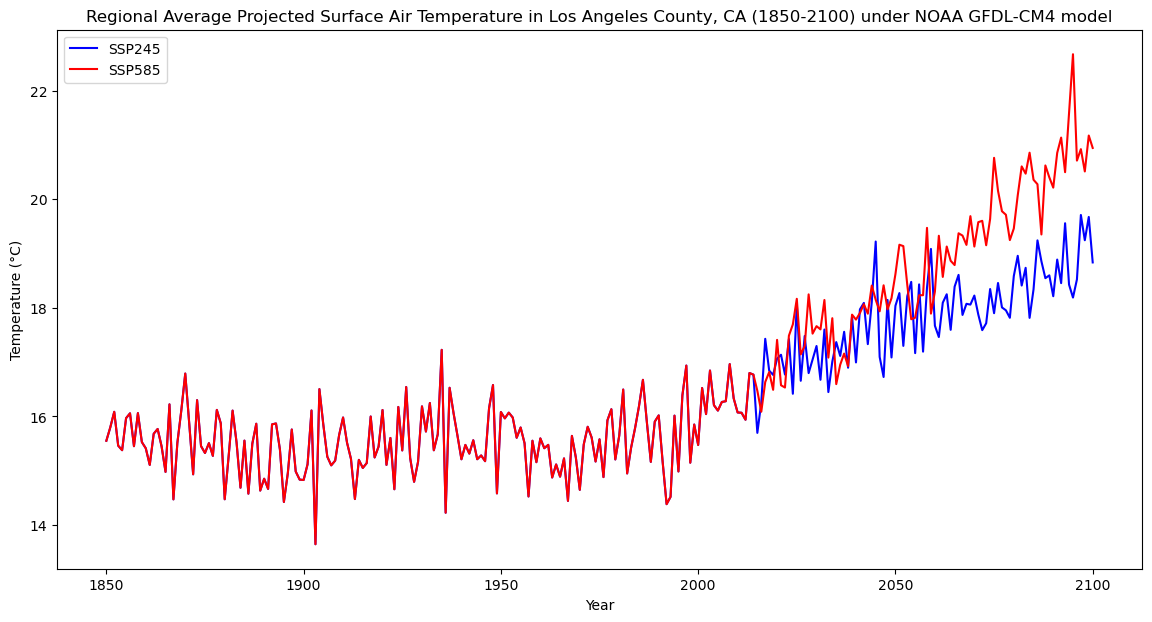

In [10]:
# Plot the time series
fig, ax = plt.subplots(figsize = (14,7))

# Plot ssp245
ax.plot(annual_mean_ssp245.year, 
        annual_mean_ssp245, 
        label = "SSP245", 
        color = "blue")

# Plot ssp585
ax.plot(annual_mean_ssp585.year, 
        annual_mean_ssp585, 
        label = "SSP585", 
        color = "red")

# Add a title
ax.set_title("Regional Average Projected Surface Air Temperature in Los Angeles County, CA (1850-2100) under NOAA GFDL-CM4 model")

# Add axis lables
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")

# Add a legend
ax.legend()

# Display plot
plt.show()

## NOAA-GFDL-ESM4

## Extract data

In [11]:
# Read in the historical data file for ESM4
hist_data = xr.open_zarr(res.df["zstore"][5], storage_options = {"anon": True})

# Read in the ssp245 data file for ESM4
ssp245_data = xr.open_zarr(res.df["zstore"][2], storage_options = {"anon": True})

# Read in the ssp585 data file for ESM4
ssp585_data = xr.open_zarr(res.df["zstore"][3], storage_options = {"anon": True})

## Data cleaning

In [12]:
# Concatenate historical and ssp245
ESM4_ssp245 = xr.concat([hist_data, ssp245_data], dim = "time")

# Concatenate historical and ssp585
ESM4_ssp585 = xr.concat([hist_data, ssp585_data], dim = "time")

# Convert time to datetime64 format
ESM4_ssp245["time"] = ESM4_ssp245.time.astype("datetime64[ns]")
ESM4_ssp585["time"] = ESM4_ssp585.time.astype("datetime64[ns]")

In [13]:
# Extract surface air temperature variable
tas_ssp245 = ESM4_ssp245["tas"]
tas_ssp585 = ESM4_ssp585["tas"]

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
lat_ssp245 = (tas_ssp245.lat >= lat_min) & (tas_ssp245.lat <= lat_max)
lon_ssp245 = (tas_ssp245.lon >= lon_min) & (tas_ssp245.lon <= lon_max)

lat_ssp585 = (tas_ssp585.lat >= lat_min) & (tas_ssp585.lat <= lat_max)
lon_ssp585 = (tas_ssp585.lon >= lon_min) & (tas_ssp585.lon <= lon_max)

# Find points where the mask value is True, drop all other points
tas_LA_ssp245 = tas_ssp245.where(lat_ssp245 & lon_ssp245, drop = True)
tas_LA_ssp585 = tas_ssp585.where(lat_ssp585 & lon_ssp585, drop = True)

# Average over lat, lon dimensions to get a time series
LA_tas_ssp245 = tas_LA_ssp245.mean(dim = ["lat", "lon"])
LA_tas_ssp585 = tas_LA_ssp585.mean(dim = ["lat", "lon"])

# Sort by time
LA_tas_ssp245 = LA_tas_ssp245.sortby("time")
LA_tas_ssp585 = LA_tas_ssp585.sortby("time")

In [14]:
# Calculate annual mean temperature
annual_mean_ssp245 = LA_tas_ssp245.groupby("time.year").mean()
annual_mean_ssp585 = LA_tas_ssp585.groupby("time.year").mean()

# Convert to Celsius
annual_mean_ssp245 = annual_mean_ssp245 - 273.15
annual_mean_ssp585 = annual_mean_ssp585 - 273.15

## Plot time series

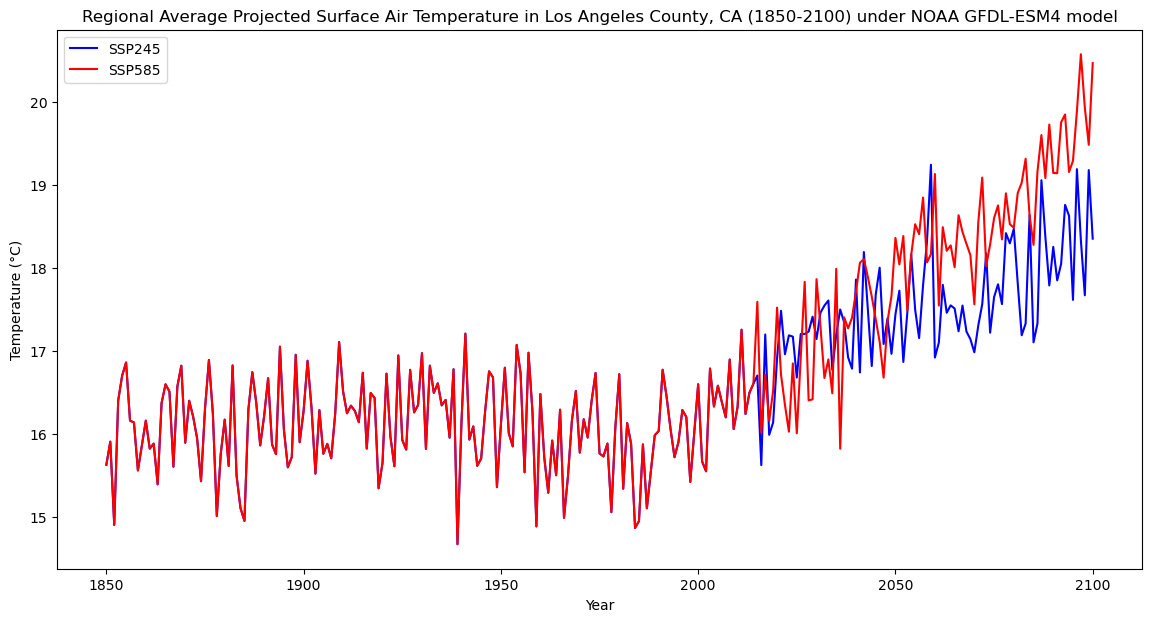

In [15]:
# Plot the time series
fig, ax = plt.subplots(figsize = (14,7))

# Plot ssp245
ax.plot(annual_mean_ssp245.year, 
        annual_mean_ssp245, 
        label = "SSP245", 
        color = "blue")

# Plot ssp585
ax.plot(annual_mean_ssp585.year, 
        annual_mean_ssp585, 
        label = "SSP585", 
        color = "red")

# Add a title
ax.set_title("Regional Average Projected Surface Air Temperature in Los Angeles County, CA (1850-2100) under NOAA GFDL-ESM4 model")

# Add axis lables
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (°C)")

# Add a legend
ax.legend()

# Display plot
plt.show()

According to the results from both climate models, there is a significant rise in surface air temperature under the fossil fuel development scenario, as expected. However, what surprised me was how closely the “middle of the road” scenario (SSP2-4.5) followed behind, despite being three tiers lower in emissions. Given the vast size and diversity of Los Angeles County, it’s crucial to examine which specific areas are most at risk. Communities near the Port of Los Angeles, oil refineries, and active oil wells may face elevated threats due to the combined effects of industrial pollution and rising temperatures. Moving forward, it is essential for L.A. County to develop strategies to mitigate these impacts — whether by reducing pollution, expanding green infrastructure, or implementing support systems to help vulnerable populations adapt to extreme heat and worsening environmental conditions.